# Persiapan Dataset 

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def read_idx_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # reshape jadi [N, 28, 28]
    return data.reshape(-1, 28, 28)

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

class MNIST_IDX_Dataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = read_idx_images(images_path)
        self.labels = read_idx_labels(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  # [1,28,28] normalisasi 0-1
        if self.transform:
            img = self.transform(img)
        return img, label

# ----------------------------------------------------
# Pakai dataset
train_dataset = MNIST_IDX_Dataset(
    images_path="/kaggle/input/fashionmnist/train-images-idx3-ubyte",
    labels_path="/kaggle/input/fashionmnist/train-labels-idx1-ubyte"
)

test_dataset = MNIST_IDX_Dataset(
    images_path="/kaggle/input/fashionmnist/t10k-images-idx3-ubyte",
    labels_path="/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte"
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Kode di atas bertujuan untuk menyiapkan data dari dataset Fashion-MNIST. Ini mendefinisikan tiga fungsi utama dan satu kelas.

- read_idx_images(filename): Fungsi ini membaca file gambar dari format IDX. Setelah membaca, data diubah menjadi array NumPy dengan bentuk [N, 28, 28], di mana N adalah jumlah gambar dan 28x28 adalah dimensi setiap gambar.

- read_idx_labels(filename): Fungsi ini membaca file label yang berisi angka-angka (0-9) yang mewakili kategori setiap gambar.

- MNIST_IDX_Dataset(Dataset): Ini adalah kelas kustom yang dibuat untuk memuat dataset Fashion-MNIST. Kelas ini mengimplementasikan metode __len__ untuk mendapatkan jumlah total data dan __getitem__ untuk mengambil satu gambar dan labelnya pada indeks tertentu. Gambar dinormalisasi (dibagi 255.0) agar nilai pikselnya berada dalam rentang 0-1, yang merupakan praktik standar dalam pelatihan model pembelajaran mesin.

- Penggunaan Dataset: Bagian terakhir dari blok ini membuat objek dataset pelatihan (train_dataset) dan pengujian (test_dataset), lalu memuatnya ke dalam DataLoader untuk memfasilitasi pelatihan model dengan batching dan pengacakan data (shuffle=True).

In [18]:
model = ConvAutoencoder(in_channels=1, latent_dim=64)


# Pelatihan Model Autoencoder

In [19]:
class ConvAutoencoder28(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # 28 -> 14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 14 -> 7
            nn.ReLU(True),
        )
        self.fc1 = nn.Linear(32*7*7, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 32*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 7 -> 14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 14 -> 28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.fc1(h)
        return z

    def decode(self, z):
        h = self.fc2(z)
        h = h.view(h.size(0), 32, 7, 7)
        xrec = self.decoder(h)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xrec = self.decode(z)
        return xrec, z


In [20]:
model = ConvAutoencoder28(latent_dim=64).to(device)
train_autoencoder(model, train_loader, device, epochs=10, lr=1e-3)


[Epoch 1/10] Recon Loss: 0.0326
[Epoch 2/10] Recon Loss: 0.0124
[Epoch 3/10] Recon Loss: 0.0097
[Epoch 4/10] Recon Loss: 0.0084
[Epoch 5/10] Recon Loss: 0.0078
[Epoch 6/10] Recon Loss: 0.0074
[Epoch 7/10] Recon Loss: 0.0071
[Epoch 8/10] Recon Loss: 0.0069
[Epoch 9/10] Recon Loss: 0.0067
[Epoch 10/10] Recon Loss: 0.0065


kode di atas adalah tempat model autoencoder dilatih.

* Inisialisasi Model: 
Kode model = ConvAutoencoder28(latent_dim=64).to(device) membuat instance baru dari model autoencoder dan memindahkannya ke perangkat yang tersedia (GPU jika ada).

* Fungsi train_autoencoder: Fungsi ini menjalankan proses pelatihan model selama sejumlah epoch. Hasil cetak yang menunjukkan "Recon Loss" (Reconstruction Loss) atau kerugian rekonstruksi. Angka kerugian ini mengukur seberapa baik model dapat merekonstruksi gambar aslinya. Semakin kecil nilai kerugian, semakin baik modelnya.  Ini adalah indikator bahwa proses pelatihan berhasil dan model sedang belajar dari data.

# Visualisasi Hasil Rekonstruksi Gambar

In [21]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, data_loader, device, n=10):
    model.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recons, _ = model(imgs)

    imgs = imgs.cpu()
    recons = recons.cpu()

    # Tampilkan n gambar pertama
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        # Asli
        axes[0, i].imshow(imgs[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        # Rekonstruksi
        axes[1, i].imshow(recons[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Asli", fontsize=12)
    axes[1, 0].set_ylabel("Rekonstruksi", fontsize=12)
    plt.show()


Kode di atas mendefinisikan fungsi visualize_reconstruction yang menggunakan pustaka matplotlib untuk menampilkan hasil dari model.

* Fungsi visualize_reconstruction: Fungsi ini mengambil sampel dari data pengujian dan mengumpankannya ke dalam model. Model kemudian menghasilkan gambar hasil rekonstruksi. Kode ini memplot baris atas yang berisi gambar asli dan baris bawah yang berisi gambar hasil rekonstruksi untuk perbandingan visual.

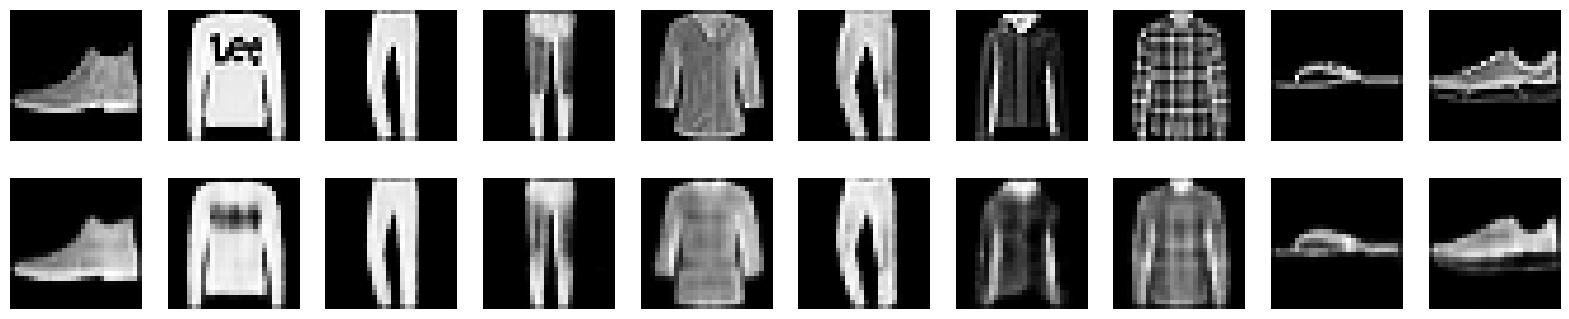

In [ ]:
visualize_reconstruction(model, test_loader, device, n=10)


Panggilan Fungsi: Kode visualize_reconstruction(model, test_loader, device, n=10) memanggil fungsi tersebut untuk menampilkan 10 gambar pertama dari data pengujian. Dengan penjelasan gambar sebagai berikut:

- Gambar Asli (Baris Atas): Ini adalah 10 gambar pertama dari dataset Fashion-MNIST (misalnya, gambar pakaian, sepatu, dan tas tangan).

- Gambar Rekonstruksi (Baris Bawah): Ini adalah versi dari gambar asli yang dihasilkan oleh model. Meskipun mungkin tidak persis sama, gambar ini menunjukkan seberapa baik model telah belajar untuk mengidentifikasi dan mereplikasi fitur-fitur penting dari gambar aslinya.

Kemampuan model untuk merekonstruksi gambar dengan baik menunjukkan bahwa bagian encoder telah berhasil mengekstrak fitur-fitur yang representatif dan informatif dari gambar, yang kemudian dapat digunakan untuk tugas-tugas lain seperti klasifikasi.

# Ekstraksi Fitur dan Klasifikasi

In [23]:
feats, labels = extract_features(model, test_loader, device)
print("Shape fitur:", feats.shape)   # [10000, 64] untuk test set


Shape fitur: torch.Size([10000, 64])


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Latih classifier sederhana
clf = LogisticRegression(max_iter=1000)
clf.fit(feats, labels)

# Prediksi
y_pred = clf.predict(feats)
print("Accuracy:", accuracy_score(labels, y_pred))


Accuracy: 0.8581


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


kode di atas menunjukkan bagaimana fitur yang diekstrak oleh autoencoder dapat digunakan untuk tugas lain, yaitu klasifikasi.

* Ekstraksi Fitur: Pertama, model autoencoder digunakan untuk mengekstrak fitur laten dari data pengujian (model.encode(x)). Fitur-fitur ini disimpan dalam variabel feats.

* Klasifikasi: Fitur-fitur ini kemudian digunakan untuk melatih Logistic Regression, sebuah model klasifikasi yang lebih sederhana. Setelah dilatih, model ini digunakan untuk memprediksi label dan mengukur akurasi.